In [64]:
import pandas as pd
import seaborn as sns


data = pd.read_csv('CaseCompetitionData.csv', sep=',')
data['actual'] = 1
data.loc[data['subsequent_purchases'] == 0, 'actual'] = 0
data = data.loc[(data['purchase_price'] !='?') & (data['customer_income'] != '?') & (data['customer_distance_to_dealer'] != '?')]
data.drop(columns=['post_purchase_satisfaction'], inplace=True)
data.head(5)

,insert_num,purchase_make,purchase_model,purchase_vehicle_year,purchase_price,trade_in,vehicle_financing,customer_age,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,actual
0,81690,DODGE,CHARGER,2010,10001 - 15000,0,0,21 - 30,20001 - 40000,U,0,9,1,0,0
1,109994,FORD,EXPLORER SPORT TRAC,2007,15001 - 20000,0,1,61 - 70,20001 - 40000,M,1,15,0,0,0
2,11399,BMW,328,2010,20001 - 25000,1,1,31 - 40,80001 - 100000,F,1,18,0,9,1
4,36685,CHEVROLET,CRUZE,2012,10001 - 15000,1,1,21 - 30,40001 - 60000,M,0,2,0,0,0
5,256143,MITSUBISHI,OUTLANDER SPORT,2011,15001 - 20000,0,1,21 - 30,40001 - 60000,M,0,12,0,0,0


In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder

In [66]:
data[['purchase_make', 'purchase_model', 'purchase_price','customer_age', 'customer_income', 'customer_gender']] = data[['purchase_make', 'purchase_model', 'purchase_price', 'customer_age', 'customer_income', 'customer_gender']].astype('category')
data['purchase_make_cat'] = data['purchase_make'].cat.codes
data['purchase_model_cat'] = data['purchase_model'].cat.codes # mapping categoricals to numerical values
data['customer_age_cat'] = data['customer_age'].cat.codes
data['customer_income_cat'] = data['customer_income'].cat.codes
data['customer_income_cat'] = data['customer_income'].cat.codes
data['purchase_price'] = data['purchase_price'].cat.codes
data['customer_distance_to_dealer'] = pd.to_numeric(data['customer_distance_to_dealer'])
data.drop(columns=['purchase_make', 'purchase_model', 'purchase_price', 'customer_age', 'customer_income', 'customer_gender', 'subsequent_purchases', 'insert_num'], inplace=True)

In [79]:
features = data.drop(columns=['actual'])
labels = data['actual']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)




In [68]:
rf = RandomForestClassifier()
scores = cross_val_score(rf, X_train, y_train.values.ravel(), cv=5)
print(scores)
parameters = {
    'n_estimators': [5, 50, 100],
    'max_depth': [2, 10, 20, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(X_train, y_train.values.ravel())
print(cv.cv_results_)
print('BEST PARAMS: {}\n'.format(results.best_params_))

means = results.cv_results_['mean_test_score']
stds = results.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, results.cv_results_['params']):
    print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

C:\Users\999Na\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\999Na\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\999Na\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\999Na\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\999Na\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

[0.62208689 0.62327785 0.62330491 0.62080446 0.62109195]
{'mean_fit_time': array([ 0.24695692,  2.02751579,  3.91386523,  0.61415811,  5.33764391,
       10.60511594,  0.95181198,  8.89282484, 17.81923633,  1.26602988,
       12.81867709, 25.04002252]), 'std_fit_time': array([0.01322031, 0.1881514 , 0.11376564, 0.07883665, 0.06954919,
       0.07482855, 0.05610985, 0.1392469 , 0.35609612, 0.05000772,
       1.08358526, 1.19181735]), 'mean_score_time': array([0.01671925, 0.10009508, 0.19182248, 0.02626734, 0.21868868,
       0.43254433, 0.05669107, 0.49152617, 0.97772326, 0.08865757,
       0.84266276, 1.58214974]), 'std_score_time': array([0.00163238, 0.0077807 , 0.00452163, 0.00541531, 0.00088571,
       0.01579483, 0.00392811, 0.02096865, 0.02172912, 0.00649099,
       0.06443444, 0.07595652]), 'param_max_depth': masked_array(data=[2, 2, 2, 10, 10, 10, 20, 20, 20, None, None, None],
             mask=[False, False, False, False, False, False, False, False,
                   False, F

NameError: name 'results' is not defined

In [69]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf.fit(X_train, y_train)
scores = rf.score(X_val, y_val)
print(scores)
predictions = rf.predict_proba(X_test)
predictions2 = rf.predict(X_test)
print(metrics.accuracy_score(y_test, predictions2))
print(metrics.classification_report(y_test, predictions2, labels=[1,0]))
print(rf.feature_importances_)
print(X_test.columns)
print(metrics.confusion_matrix(y_test, predictions2, labels=[1,0]))

# looks like vehicle year, trade in, financing, previous purchase, distance, and warranty are most telling

0.6723779517328743
0.6743755481209601
              precision    recall  f1-score   support

           1       0.66      0.01      0.02     20153
           0       0.67      1.00      0.80     41421

    accuracy                           0.67     61574
   macro avg       0.67      0.50      0.41     61574
weighted avg       0.67      0.67      0.55     61574

[0.23596363 0.28818198 0.04330827 0.14481972 0.09628793 0.10670499
 0.0165774  0.01936357 0.01493044 0.03386206]
Index(['purchase_vehicle_year', 'trade_in', 'vehicle_financing',
       'customer_previous_purchase', 'customer_distance_to_dealer',
       'vehicle_warranty_used', 'purchase_make_cat', 'purchase_model_cat',
       'customer_age_cat', 'customer_income_cat'],
      dtype='object')
[[  216 19937]
 [  113 41308]]


20153
17840
53641
61574
0.32891524117846604
0.3272972358462988
[6157, 6157, 6157, 6157, 6157, 6157, 6157, 6157, 6157, 6161]


,purchase_vehicle_year,trade_in,vehicle_financing,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,purchase_make_cat,purchase_model_cat,customer_age_cat,customer_income_cat,prob_yes,actual
295434,2008,0,1,0,5,0,5,334,2,7,0.299655,0
78292,2011,1,1,0,6,0,28,658,5,0,0.330525,0
143534,2011,1,1,0,71,0,9,257,3,1,0.334086,0
146514,2011,1,1,0,7,0,32,137,5,6,0.333753,1
199272,2011,0,1,0,7,1,28,504,3,8,0.303949,1


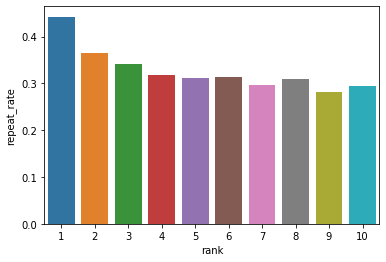

In [76]:
results = {'actual':y_test, 'prob_not':predictions[:,0], 'prob_yes':predictions[:,1]}
results = pd.DataFrame(results)
repeats = results[results['actual'] == 1]
print(len(repeats))
print(len(repeats[repeats['prob_yes'] >= .3]))
print(len(results[results['prob_yes'] >= .3]))
print(len(results))
print(results['prob_yes'].mean())
x = round(len(results)/10)

recreate = X_test
recreate['prob_yes'] = predictions[:,1]
recreate['actual'] = y_test
print(recreate['actual'].mean())

results.sort_values(by=['prob_yes'], ascending=False, inplace=True)
results.reset_index(inplace=True)
results.rename(columns={'index':'customer'}, inplace=True)
results
rank = []
repeat_rate = []
sales_rank_probs = []
lengths = []

for num in range(1,11):
    if num == 10:
        y = results.iloc[x*(num-1):]
        rr = len(results.iloc[x*(num-1):])
    else:
        y = results.iloc[x*(num-1):x*num]
        rr = len(results.iloc[x*(num-1):x*num])
    z = y['actual'].sum()/len(y)
    sales_rank_probs.append(results.iloc[x*(num-1)]['prob_yes'])
    rank.append(num)
    repeat_rate.append(z)
    lengths.append(rr)

sales_rank_probs.append(0)
sales_rank = {'rank':rank, 'repeat_rate':repeat_rate}
sales_rank = pd.DataFrame(sales_rank)
print(lengths)
sales_rank.head(10)

sns.barplot(x='rank', y='repeat_rate', data=sales_rank)
recreate.head()

In [ ]:
features = data.drop(columns=['actual'])
labels = data['actual']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [83]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
print(fpr)
print(tpr)
print(thresholds)

C:\Users\999Na\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.         0.         0.         ... 0.99995172 0.99995172 1.        ]
[0.00000000e+00 4.96204039e-05 9.92408078e-05 ... 9.99900759e-01
 1.00000000e+00 1.00000000e+00]
[1.42189033 0.42189033 0.42026614 ... 0.27827537 0.27754316 0.27304583]


In [86]:
logit__roc_auc1 = roc_auc_score(y_test, logreg.predict(X_test))


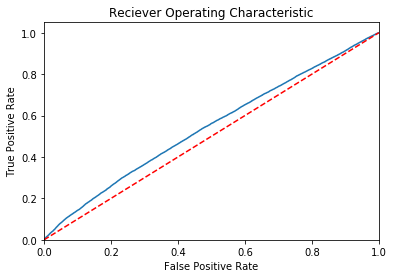

In [87]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (Sensitivity = %0.3f)' % logit__roc_auc1)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1.0])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciever Operating Characteristic')
plt.show()